# 03. Neural Networks in PyTorch

In the previous notebook ([02. Linear Regression in PyTorch](02_linear_regression_pytorch.ipynb)), we gave an overview of how neural networks work.

In this notebook, we will implement a neural network using PyTorch. We will create a straight line, and build a PyTorch model to fit this line.

The main steps of a standard PyTorch workflow are:

1. **Prepare the data**: Load and preprocess the data.
2. **Define the model**: Create a neural network model.
3. **Define the loss function**: Specify how to measure the model's performance.
4. **Define the optimizer**: Choose an optimization algorithm to update the model's parameters.
5. **Train the model**: Run the training loop to optimize the model's parameters.
6. **Evaluate the model**: Test the model on unseen data to check its performance.
7. **Make predictions**: Use the trained model to make predictions on new data.
8. **Improve the model**: Adjust hyperparameters, architecture, or data preprocessing based on evaluation results.
9. **Save the model**: Save the trained model for future use.


## Prepare the Data

In this example, we will create a simple dataset that represents a straight line. We will generate some random data points around this line to simulate real-world data.

It's important to note that in a real-world scenario, you would typically load your dataset from a file or a database. However, for this example, we will generate synthetic data.

We'll use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.


In [114]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [115]:
# Known parameters
weight = 0.7
bias = 0.3

# Generate synthetic data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)  # Shape: (50, 1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

Now we need to create a model that can learn the relationship between `X` (features) and `y` (targets/labels).

### Split Data into Training and Testing Sets

We will split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance. Sometimes, we also use a validation set to tune hyperparameters, but for simplicity, we will only use training and testing sets in this example.

Each split of the dataset serves a different purpose:
| Split | Purpose | Amount of total data | How often is it used? |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------- | -------------------- | --------------------- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |


In [116]:
train_split = int(0.8 * len(X))  # 80% for training, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Training Length: {len(X_train)}")
print(f"Testing Length: {len(X_test)}")

Training Length: 40
Testing Length: 10


One of the most important things in machine learning is familiarizing yourself with the data. This is often done by visualizing the data.

Let's create a function to visualize the data points and the line we want to fit.


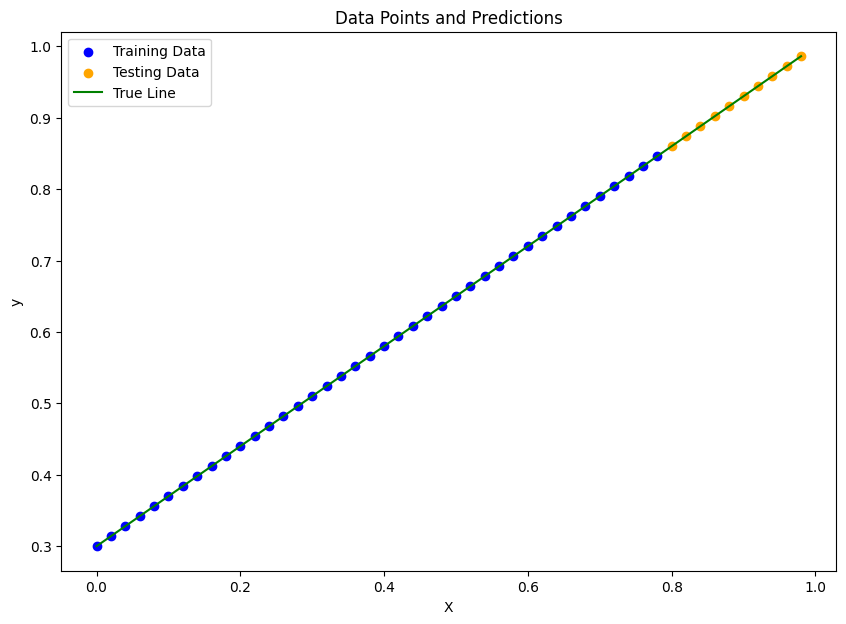

In [117]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, color="blue", label="Training Data")
    plt.scatter(test_data, test_labels, color="orange", label="Testing Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, color="red", label="Predictions")

    plt.plot(X, weight * X + bias, color="green", label="True Line")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Data Points and Predictions")
    plt.legend()
    plt.show()


plot_predictions()

## Build Model


In [118]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(
                1,  # <- start with random weights (this will get adjusted as the model learns)
                dtype=torch.float,
            ),
            requires_grad=True,
        )  # <- can we update this value with gradient descent?

        self.bias = nn.Parameter(
            torch.randn(
                1,
                dtype=torch.float,
            ),
            requires_grad=True,
        )

    # Forward defines the computation in the model
    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:  # <- "x" is the input data (e.g. training/testing features)
        return (
            self.weights * x + self.bias
        )  # <- this is the linear regression formula (y = m*x + b)

Let's explain what the code above means.

- `nn.Module` is the base class for all neural network modules in PyTorch. By inheriting from `nn.Module`, we can create our own custom neural network models.
- Initializing `model parameters` is done using `nn.Parameter`, which allows us to create parameters that can be optimized during training. In this case, we are creating a weight and a bias for our linear regression model.
- `requires_grad=True` means that these parameters will be updated during the training process using gradient descent. PyTorch will automatically compute the gradients for these parameters during backpropagation.
- Any subclass of `nn.Module` should implement the `forward` method, which defines how the input data flows through the model. In this case, we are implementing a simple linear regression model that computes the output as a linear combination of the input features and the model parameters (weights and bias).

### Check Model Content


In [119]:
torch.manual_seed(42)  # For reproducibility

model_0 = LinearRegressionModel()

list(model_0.parameters())  # List of model parameters (weights and bias)

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

Another method to check the model content is using `state_dict()`, which returns a dictionary containing all the parameters of the model.


In [120]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Notice how the values are random. This is because we initialized the model with random weights and biases. The model will learn these parameters during training.

Let's make predictions using this untrained model.

### Making Predictions


In [121]:
with torch.inference_mode():
    y_preds = model_0(X_test)

Now let's explain why we use `torch.inference_mode()` as a [context manager](https://realpython.com/python-with-statement/). `inference` just means `making predictions`, which means we are not training the model, we are just using it to make predictions.

`torch.inference_mode()` is used to disable gradient tracking, which is not needed during inference (making predictions). This can save memory and improve performance. In older versions of PyTorch, you might see `torch.no_grad()` used for the same purpose, but `inference_mode` is more efficient and recommended for inference tasks.


In [122]:
print(f"Number of Test Samples: {len(X_test)}")
print(f"Number of Predictions: {len(y_preds)}")
print(f"Predicted Values: {y_preds}")

Number of Test Samples: 10
Number of Predictions: 10
Predicted Values: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


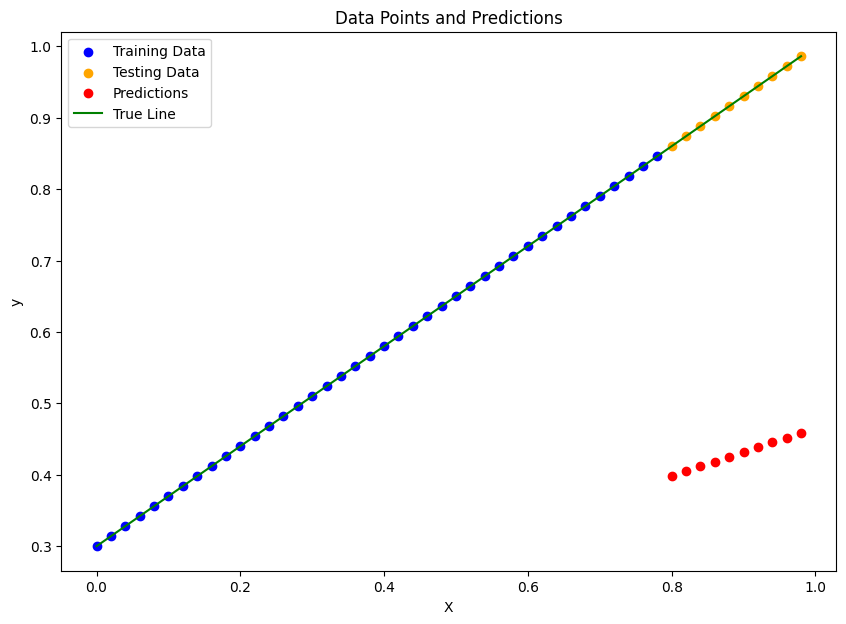

In [123]:
plot_predictions(predictions=y_preds)

Notice how those predictions look pretty bad, which makes sense because our model is not trained yet. As we train the model, we expect the predictions to improve.

## Train Model

Currently our model is guessing randomly, so we need to train it to learn the relationship between `X` and `y`.

### Loss Function and Optimizer

For our model to learn, we need to define a loss function and an optimizer.

| Function          | What does it do?                                                                                                                 | Where does it live in PyTorch?                                                                                             | Common values                                                                                                                                                                                                                                                                                 |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions).     | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)). |
| **Optimizer**     | Tells your model how to update its internal parameters to best lower the loss.                                                   | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)).                               |

For more information on how to choose loss functions, you can view:

- [Beginners Guide to PyTorch Loss Functions](https://zerotomastery.io/blog/pytorch-loss-functions/)
- [Loss Function in Machine Learning](https://www.datacamp.com/tutorial/loss-function-in-machine-learning)
- [Guide to PyTorch Loss Functions](https://medium.com/biased-algorithms/guide-to-pytorch-loss-functions-90ab7ca85ec2)

For our problem, we will use the [Mean Absolute Error (MAE)](https://arize.com/blog-course/mean-absolute-error-in-machine-learning-what-you-need-to-know/) loss function, which is `torch.nn.L1Loss()`.

There are many optimizers available in PyTorch, but we will use SGD (Stochastic Gradient Descent) for this example, which is `torch.optim.SGD()`. The inputs to the optimizer are:

- `params`: the parameters of the model that we want to optimize (in this case, `model_0.parameters()`).
- `lr`: the learning rate, which controls how much to change the model parameters at each step. A common starting point is `0.01`, but you can experiment with different values to see what works best for your problem.


In [124]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Training Loop

It's time to create a **training loop** and **testing loop**.

The training loop is where the model learns from the training data. Whereas the testing loop is where we evaluate the model's performance on unseen data.

The training loop consists of the following steps:

1. **Forward pass**: Pass the input data through the model to get predictions.
2. **Calculate loss**: Compare the model's predictions with the true labels using the loss function.
3. **Zero gradients**: Clear the gradients of the model parameters to prepare for the next iteration.
4. **Backward pass**: Compute the gradients of the loss with respect to the model parameters.
5. **Optimizer step**: Update the model parameters using the optimizer.


In [125]:
torch.manual_seed(42)

# Define the number of epochs
# This is the number of times the model will see the entire training dataset
EPOCHS = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(EPOCHS):
    ### Training

    # Set the model to training mode
    model_0.train()

    # 1. Forward pass: Compute predictions
    y_train_pred = model_0(X_train)

    # 2. Calculate the loss
    train_loss = loss_fn(y_train_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backward pass: Compute gradients
    train_loss.backward()

    # 5. Update the weights
    optimizer.step()

    ### Testing

    # Set the model to evaluation mode
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass: Compute predictions
        y_test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(y_test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(train_loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(
                f"Epoch: {epoch} | MAE Train Loss: {train_loss:.5f} | MAE Test Loss: {test_loss:.5f}"
            )

Epoch: 0 | MAE Train Loss: 0.31288 | MAE Test Loss: 0.48107
Epoch: 10 | MAE Train Loss: 0.19767 | MAE Test Loss: 0.34636
Epoch: 20 | MAE Train Loss: 0.08909 | MAE Test Loss: 0.21730
Epoch: 30 | MAE Train Loss: 0.05315 | MAE Test Loss: 0.14464
Epoch: 40 | MAE Train Loss: 0.04544 | MAE Test Loss: 0.11361
Epoch: 50 | MAE Train Loss: 0.04168 | MAE Test Loss: 0.09920
Epoch: 60 | MAE Train Loss: 0.03819 | MAE Test Loss: 0.08887
Epoch: 70 | MAE Train Loss: 0.03476 | MAE Test Loss: 0.08059
Epoch: 80 | MAE Train Loss: 0.03132 | MAE Test Loss: 0.07232
Epoch: 90 | MAE Train Loss: 0.02789 | MAE Test Loss: 0.06474


Notice how both the training and test loss are decreasing over time. This is a good sign that our model is learning.

Let's plot out loss curves to visualize the training and testing loss over epochs.


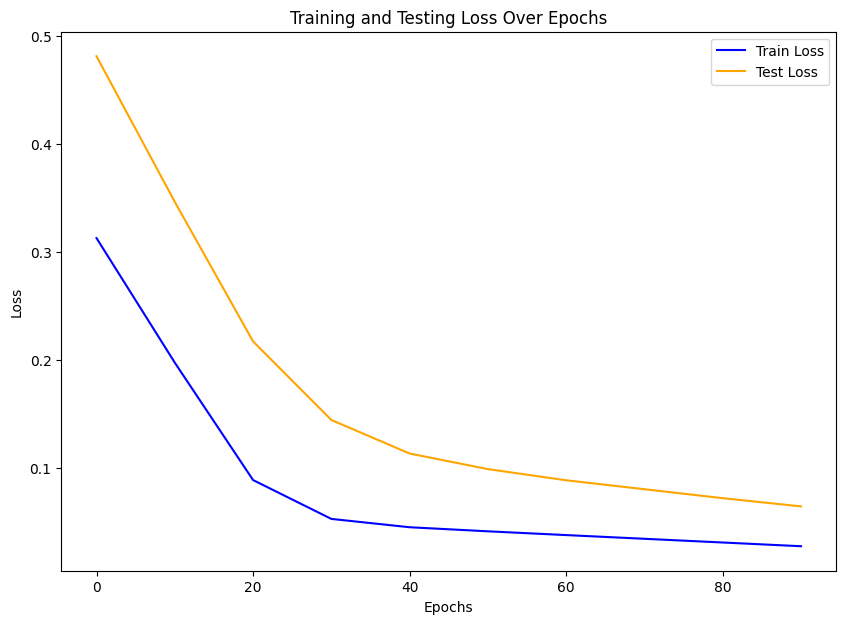

In [126]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, label="Train Loss", color="blue")
plt.plot(epoch_count, test_loss_values, label="Test Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.legend()

Both **loss curves** are going down over time, which means that our model is learning.

Because of the loss function and optimizer, the model's `weights` and `bias` are being updated to minimize the loss. This is the essence of training a neural network: adjusting the model parameters to make better predictions.

Now that we have trained our model, we can make predictions on the test set and visualize the results.

### Make Predictions With Trained Model

There are three things we need to remember when making predictions with a trained model:

1. **Set the model to evaluation mode**: This is important because it tells the model that we are in the inference phase, and it should not update any weights or biases.

2. **Use `torch.inference_mode()`**: This context manager disables gradient tracking, which reduces memory consumption and speeds up computations.

3. **Same device**: Ensure that the input data is on the same device (CPU or GPU) as the model.


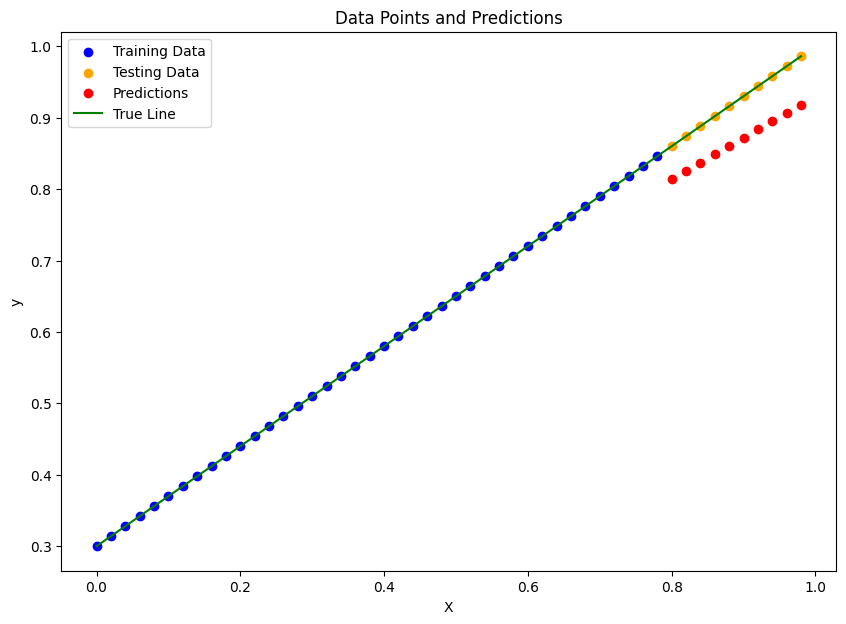

In [127]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

As we can see, the predictions are much better than before. The model has learned the relationship between `X` and `y` and can now make accurate predictions on unseen data.


## Saving and Loading a Model

After training a model, you might want to save it for later use. PyTorch provides a simple way to save and load models using the `torch.save()` and `torch.load()` functions.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method                                                                                                                                                | What does it do?                                                                                                                                                                                                        |
| ------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save)                                                                          | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`. |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load)                                                                  | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).         |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict) | Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object.                                                                                                                        |

### Saving a Model

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Here are the three steps we will take to save a model's `state_dict()`:

1. Create a `models` directory.
2. Create a file path to save the model to.
3. Call `torch.save()` on the model's `state_dict()` and pass in the file path.


In [128]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_linear_regression_model.pth


### Loading a Model


In [129]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

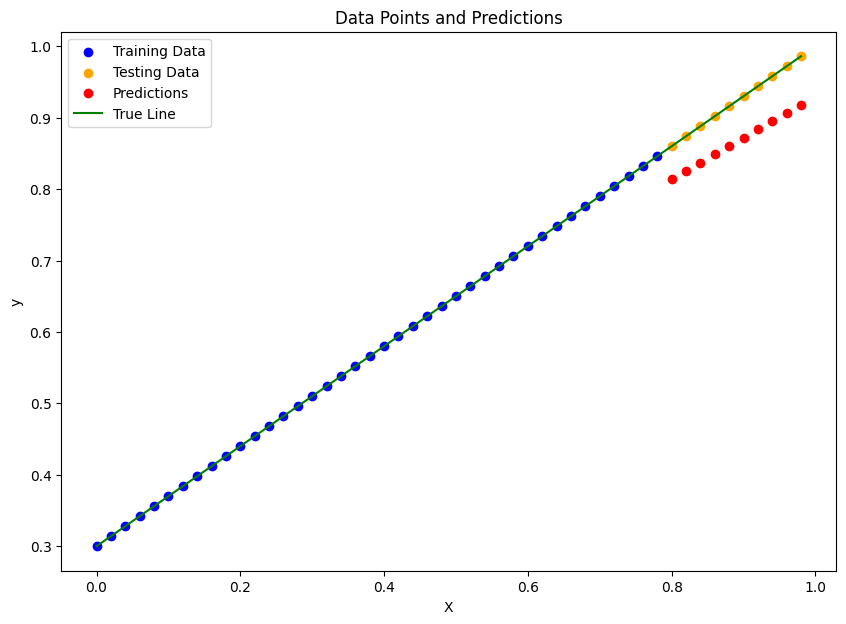

In [130]:
loaded_model_0.eval()

with torch.inference_mode():
    y_preds = loaded_model_0(X_test)

plot_predictions(predictions=y_preds)

It looks like our model has been loaded successfully. We can now use it to make predictions on new data.


## Exercises

To reinforce your understanding, try the following exercises:

1. **Change the Learning Rate**: Experiment with different learning rates (e.g., 0.001, 0.1) and observe how it affects the training process and final predictions.
2. **Add More Data**: Generate more data points to see if the model's performance improves with more training data.
3. **Change the Model Architecture**: Modify the model to include more layers or different activation functions. Observe how these changes affect the model's performance.
4. **Implement a Validation Set**: Split the data into training, validation, and testing sets. Use the validation set to tune hyperparameters and prevent overfitting.
5. **Experiment with Different Loss Functions**: Try using different loss functions (e.g., Mean Squared Error, Huber Loss) and see how they affect the model's performance.
6. **Visualize Predictions**: Create a function to visualize the model's predictions on the test set. Compare the predicted values with the true values to see how well the model is performing.
7. **Save and Load the Model**: Implement saving and loading the model using `torch.save()` and `torch.load()`. Test if the loaded model can make predictions on new data.
8. **Experiment with Different Optimizers**: Try using different optimizers (e.g., Adam, RMSprop) and see how they affect the training process and final predictions.
